Analizing Dataset for ifood-data-business-analyst-test-latam-main

By: Alejandro Rojas Benítez
https://www.linkedin.com/in/arojasb3/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
from scipy.stats import norm
from scipy import stats
import warnings
from scipy import stats
from copy import deepcopy
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# We will import the data saving it as a Pandas DataFrame Object
df1 = pd.read_csv('ml_project1_data.csv')

## Variables Description

We can find the description of 25 variables, taken from the attached pdf file to the dataset 'iFood CRM Data Analyst Case.pdf':

AcceptedCmp1 : 1 if customer accepted the offer in the 1st campaign, 0 otherwise

AcceptedCmp2 : 1 if customer accepted the offer in the 2nd campaign, 0 otherwise

AcceptedCmp3 : 1 if customer accepted the offer in the 3rd campaign, 0 otherwise

AcceptedCmp4 : 1 if customer accepted the offer in the 4th campaign, 0 otherwise

AcceptedCmp5 : 1 if customer accepted the offer in the 5th campaign, 0 otherwise

Response : 1 if customer accepted the offer in the last campaign, 0 otherwise

Complain : 1 if customer complained in the last 2 years

DtCustomer : date of customer's enrollment with the company

Education : customer's level of education

Marital : customer's marital status

Kidhome : number of small children in customer's household

Teenhome : number of teenagers in customer's household

Income : customer's yearly household income

MntFishProducts : amount spent on fish products in the last 2 years

MntMeatProducts : amount spent on meat products in the last 2 years

MntFruits : amount spent on fruits in the last 2 years

MntSweetProducts : amount spent on sweet products in the last 2 years

MntWines : amount spent on wines in the last 2 years

MntGoldProds : amount spent on gold products in the last 2 years

NumDealsPurchases : number of purchases made with discount

NumCatalogPurchases : number of purchases made usuing catalogue

NumStorePurchases : number of purchases made directly in stores

NumWebPurchases : number of purchaes made through company's web site

NumWebVisitsMonth : number of visits to company's web site in the last month

Recency : number of days since last purchase

In [3]:
# We want to be sure the variables in the .csv are the same one mentioned in the pdf file
df1.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

In [4]:
len(df1.columns)

29

Well, we can see there are 4 variables which are not described in the pdf: `ID`, `Year_Birth`, `Z_revenue`, `Z_CostContract`.

The first two make complete sense so there is no description needed, lets find out what both Z variables hide in case they are important or not.

In [5]:
# Lets create some variables for fast access to important variables
campaings = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']
undocummented = ['Z_CostContact', 'Z_Revenue']

In [6]:
df1[undocummented].describe()

,Z_CostContact,Z_Revenue
count,2240.0,2240.0
mean,3.0,11.0
std,0.0,0.0
min,3.0,11.0
25%,3.0,11.0
50%,3.0,11.0
75%,3.0,11.0
max,3.0,11.0


We can see than both have only one value, 3 for `Z_CostContact` and 11 for `Z_Revenue`.

For sure these two variables have nothing important to tell, lets get rid of them.

In [7]:
df1 = df1.drop(columns=undocummented);

### New Variables

Now lets swap some of those date/year variables into some new ones, more numerical:

`age` : The age of the customers. 2021 - Year_Birth

`enrollment_time` : days of enrollment of the customers. Assuming 12/31/2020 - Dt_Customer

We find out that `enrollment_time` in days make sense given the fact that `Recency` is also on days.

In [8]:
def find_days(target, current, date_format = "%Y-%m-%d"):
    """from solution of 
    https://stackoverflow.com/questions/151199/how-to-calculate-number-of-days-between-two-given-dates"""
    a = datetime.strptime(current, date_format)
    b = datetime.strptime(target, date_format)
    delta = b - a
    return delta.days

# new variables
df1['age'] = 2021 - df1['Year_Birth']
df1['enrollment_time'] = df1.apply(lambda row: find_days('2020-12-31', row['Dt_Customer']), axis=1)

### NaNs?
Lets look for any NaNs in our dataset

In [9]:
# NaNs?
df1.columns[df1.isna().any()].tolist()

['Income']

Well, if we have NaNs on Income, one may think two possible cases: 

- They could mean those customers have no income.
- The information is just missing. 

Let's find out if there are customers with an income value of zero and how many NaNs we have.

In [10]:
# looking for the minimum value in the column
df1['Income'].describe()

count      2216.000000
mean      52247.251354
std       25173.076661
min        1730.000000
25%       35303.000000
50%       51381.500000
75%       68522.000000
max      666666.000000
Name: Income, dtype: float64

In [11]:
# Number of NaNs
df1['Income'].isna().sum() 

24

### Outliers?
Before removing any NaNs from the dataset, we will search for outliers on some of the variables, we may be lucky and probably will remove outliers that have NaN `Income`.

In [12]:
numerical_cols = [ 'Income', 'Kidhome',
       'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
                 'age', 'enrollment_time']

categorical_cols = ['Education', 'Marital_Status', 'Complain']

In [13]:
def plot_histograms(df, horizontal, vertical, columns, figsize=(16,8), function = sns.histplot, df2 = None, label=None):
    """this function will make easier to plot all the histograms"""
    fig, axes = plt.subplots(horizontal, vertical, figsize=figsize)

    fig.tight_layout()
    for i, var in enumerate(columns):
        if df2 is None:
            lm = function( df[var], ax=list(axes.flat)[i]);
        else:
            lm = function( df[var], ax=list(axes.flat)[i]);
            lm2 = function( df2[var], ax=list(axes.flat)[i]);
    if df2 is not None:
        fig.legend(labels=label)

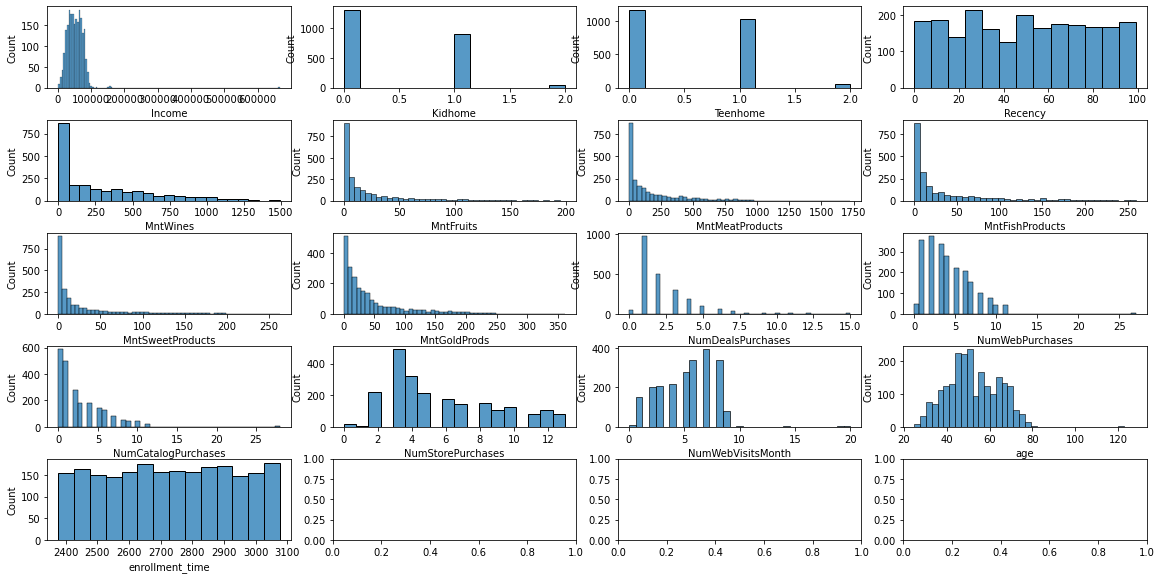

In [14]:
plot_histograms(df1, 5, 4, numerical_cols)

We can clearly see some outliers on the following variables:
- `Income`
- `NumWebPurchases`
- `NumCatalogPurchases`
- `NumWebVisitsMonth`
- `age`
- `MntMeatProducts`

In [15]:
outliers = ['Income', 'NumWebPurchases', 'NumCatalogPurchases', 'NumWebVisitsMonth', 'age', 'MntMeatProducts']

Since we have around 2240 customers and all outliers seem to be extreme large values instead of small values, lets start by listing the top 10 largest values on all those variables.

In [16]:
for o in outliers:
    print(df1[o].nlargest(10))

2233    666666.0
617     162397.0
687     160803.0
1300    157733.0
164     157243.0
1653    157146.0
2132    156924.0
655     153924.0
1898    113734.0
646     105471.0
Name: Income, dtype: float64
27      27
1898    27
1975    25
1806    23
18      11
67      11
131     11
175     11
202     11
209     11
Name: NumWebPurchases, dtype: int64
21      28
687     28
1653    28
164     22
104     11
288     11
586     11
591     11
627     11
636     11
Name: NumCatalogPurchases, dtype: int64
9       20
774     20
1245    20
1042    19
1846    19
1328    17
981     14
1524    14
2214    13
47      10
Name: NumWebVisitsMonth, dtype: int64
239     128
339     122
192     121
1950     81
424      80
39       78
358      78
415      78
894      78
1150     78
Name: age, dtype: int64
21      1725
1653    1725
687     1622
2228    1607
164     1582
1358     984
1808     981
456      974
2109     968
1031     961
Name: MntMeatProducts, dtype: int64


Just printing the 10 largest values on all 6 columns we can find that the following values start to be "out of range" of the remaining ones:
- `Income` -> 8
- `NumWebPurchases` -> 4
- `NumCatalogPurchases` -> 4
- `NumWebVisitsMonth` -> 9
- `age` -> 3
- `MntMeatProducts` -> 5

In [17]:
# creating a list of tuples like ('variable_name', <number_of_possible_outliers>)
rem_outliers = zip(outliers, [8, 4, 4, 9, 3, 5])
indexes = set()

# saving outliers indexes
for o, i in rem_outliers:
    indexes.update(list(df1[o].nlargest(10).index[0:i]))
len(indexes)

26

We now created a list with all the indexes that contain those possible outliers. We didn't remove them as soon as we got the index in case there were some repeated indexes, we want to be careful when removing customers.

In [18]:
df2 = df1.drop(index=pd.Index(indexes))

Now that we removed some outliers, lets find out how our histograms are

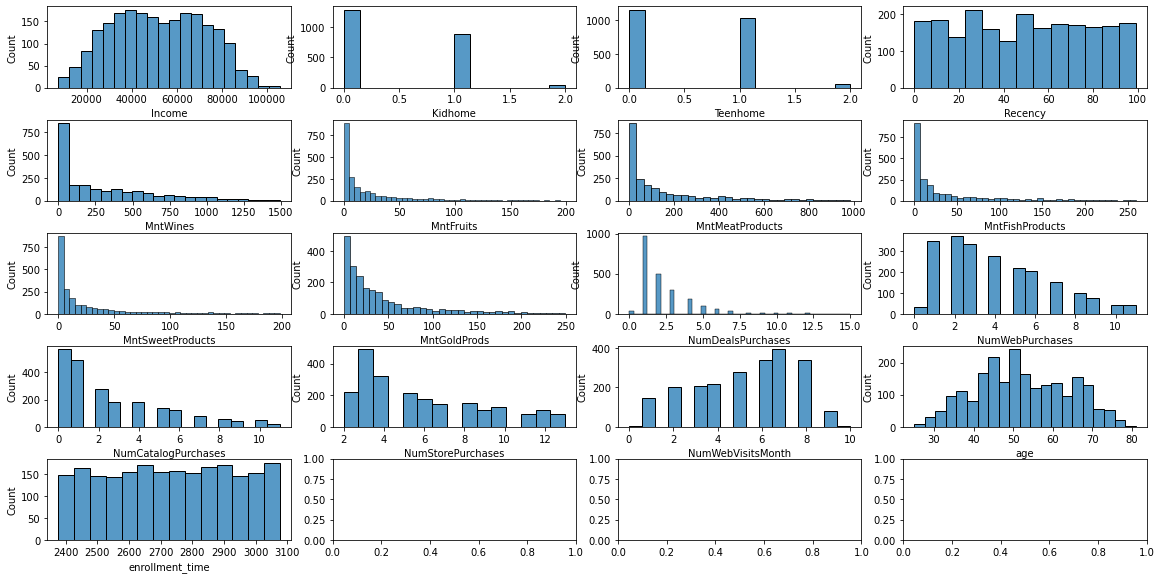

In [19]:
plot_histograms(df2, 5, 4, numerical_cols)

They look a lot better now...

But no, we are not ready, lets look for outliers in our categorical variables.

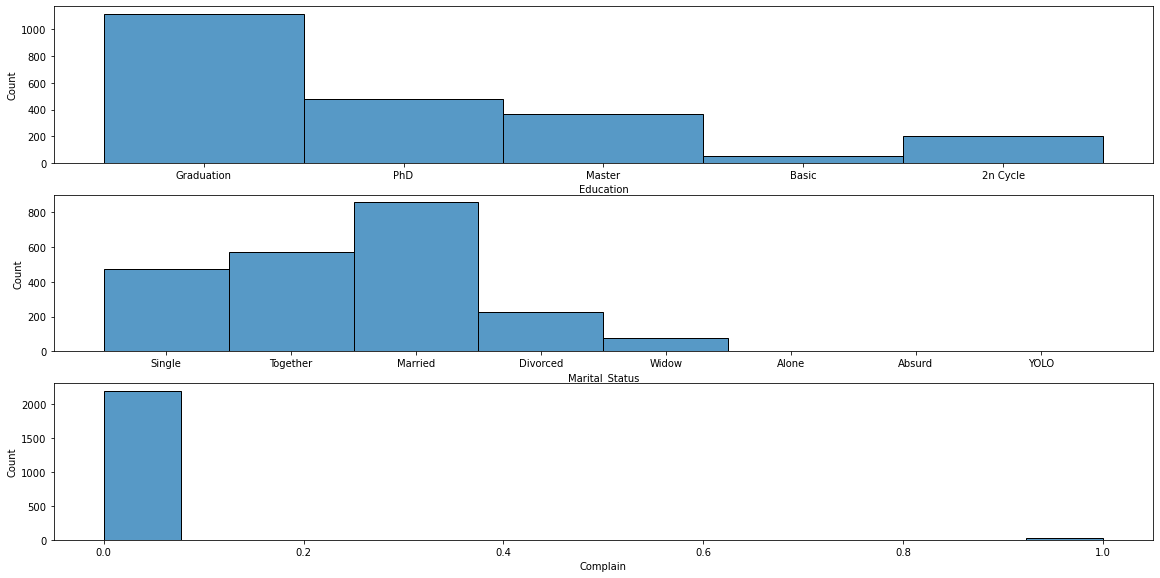

In [20]:
plot_histograms(df2, 3, 1, categorical_cols)

In [21]:
for cat in categorical_cols:
    print(df2[cat].value_counts())

Graduation    1116
PhD            476
Master         368
2n Cycle       200
Basic           54
Name: Education, dtype: int64
Married     857
Together    572
Single      473
Divorced    228
Widow        77
Alone         3
YOLO          2
Absurd        2
Name: Marital_Status, dtype: int64
0    2194
1      20
Name: Complain, dtype: int64


- `Education` : everything seems fine.
- `Marital_Status` : Definetly Alone, Absurd and YOLO seem to be noise in the dataset.
- `Complain` : this variable may not have a lot of importance, anyway lets keep if for the moment.

In [22]:
for cat in ['Alone', 'Absurd', 'YOLO']: 
    df2.drop(df2[df2['Marital_Status'] == cat].index, inplace = True)

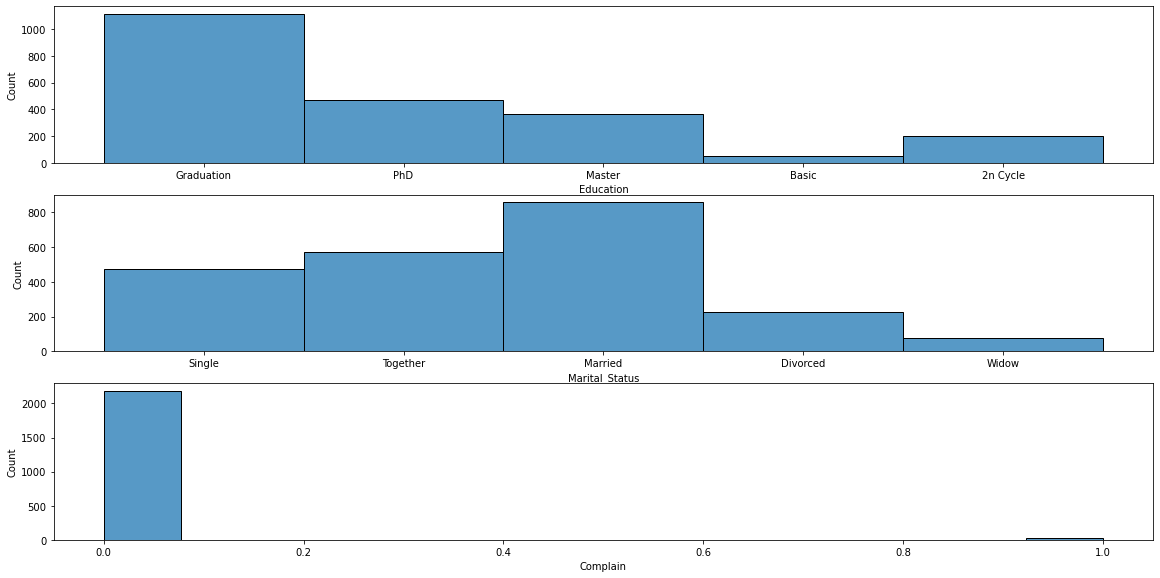

In [23]:
plot_histograms(df2, 3, 1, categorical_cols)

Now it looks a lot better.

Remember the NaNs we didn't remove at the begginging? Lets look if we removed some with this outlier removal

In [24]:
# Number of NaNs
df2['Income'].isna().sum() 

22

Hmmm, we only removed 2 NaN values. Since there are only 22 left, lets just proceed to remove them from the dataset.

In [25]:
df2.dropna(inplace=True)

### Splitting data with last campaign

Now, with our data without some outliers and NaNs, We will now split our dataset into the ones that had a positive and a negative answer regarding the last campaign

In [26]:
dfpositive = df2[df2['Response'] == 1]
dfnegative = df2[df2['Response'] == 0]

Initially we will just plot histograms of all the numerical variables 

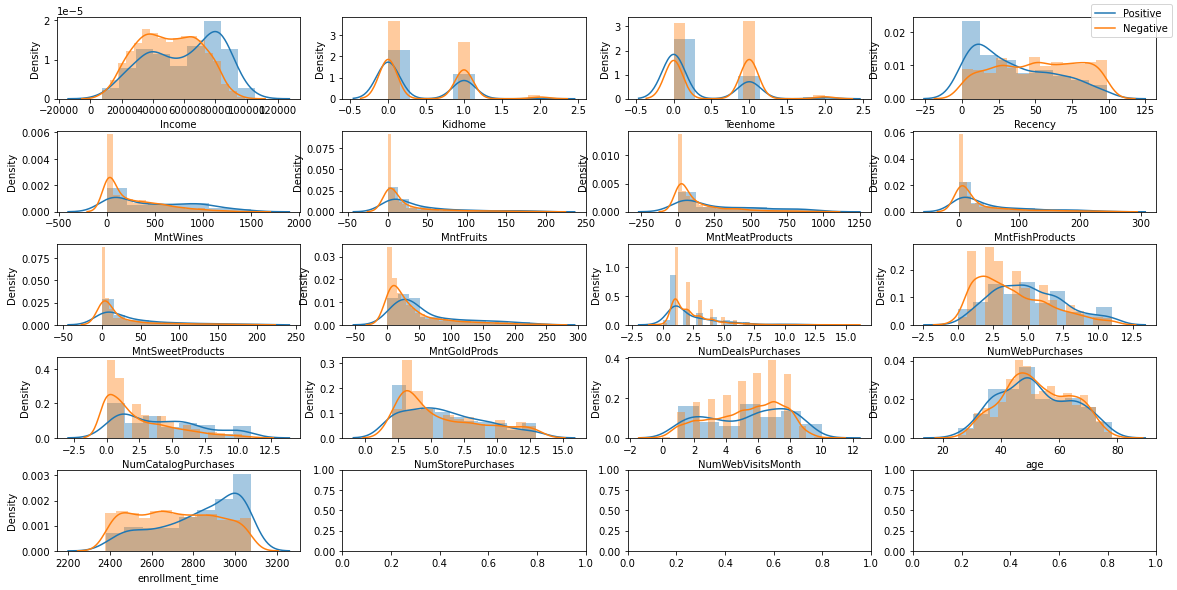

In [27]:
plot_histograms(dfpositive, 5, 4, numerical_cols, function=sns.distplot, df2=dfnegative, label=['Positive', 'Negative'])

So lets start looking at some of those variables:

- `Income` : We can see that customers that earn aroun 70k and 80k are much more probable to like the campaign.
- `Kidhome` : Both histograms are pretty alike, this may be not be important.
- `Teenhome` : Most of the customers that accepted had 0 no teens.
- `Resency` : Customers with lower recency preferred the campaign.
- `Amount spent on products` : Customers that spend money wine seemed to be more interested in the campaign. Also meat and gold but not as noticeable.
- `Number of purchases with discounts` : Both histograms seem alike.
- `Number of web purchases` : Customers that do more than 2 web purchases.
- `Number of catalog purchases` : Not as heavy on customers with 0 catalog purchases and the ones with negative answer, and a lot more on customers with 5 to 7.
- `Number of store purchases` : Lower on 2-3 purchases, higher on 5-7.
- `Number of web visits` : Pretty similar histograms.
- `Age`: Both histograms seem to be alike, probably not as important as one may think. Anyway a lot of more people around 40 years old preferred the campaign.
- `enrollment time` : customers with high enrollment time, more than 2800 days.

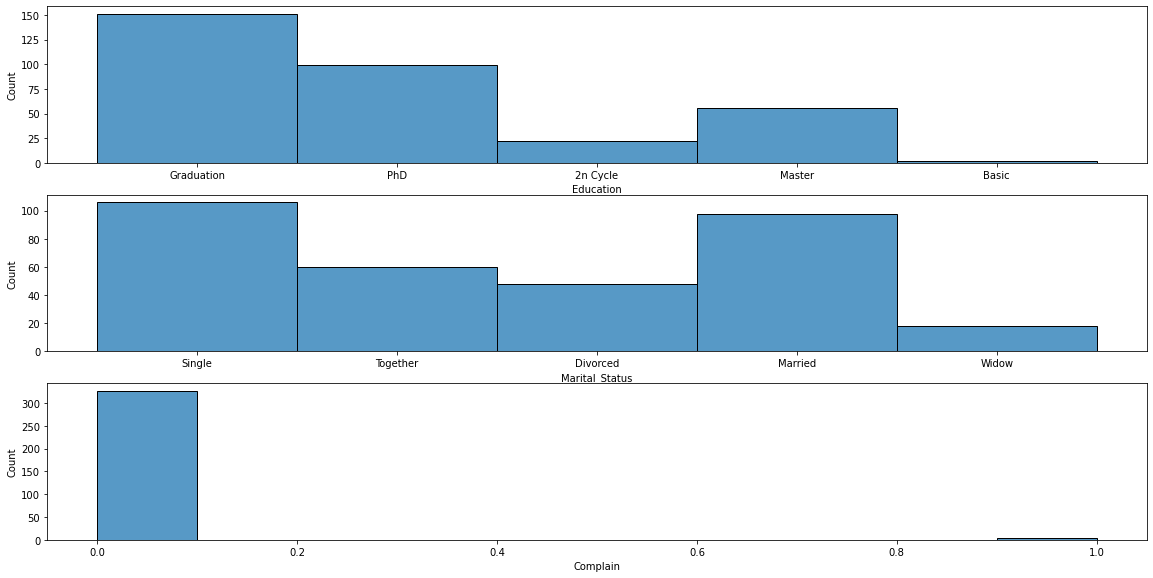

In [28]:
plot_histograms(dfpositive, 3, 1, categorical_cols, function=sns.histplot)

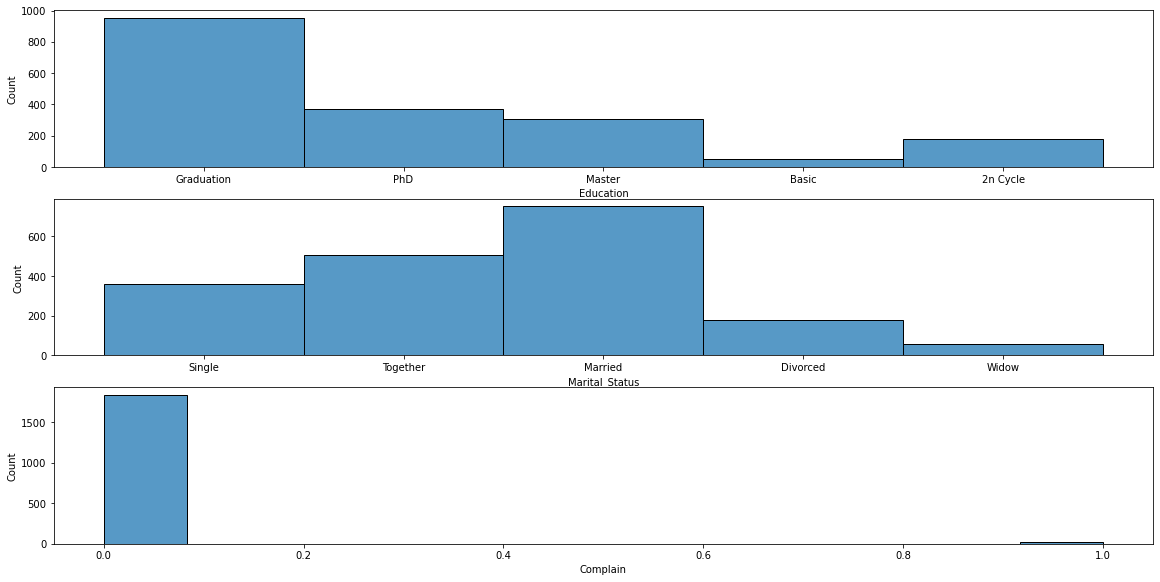

In [29]:
plot_histograms(dfnegative, 3, 1, categorical_cols, function=sns.histplot)

Regarding the categorical variables we find that:
- `Education` : Cannot conclude.
- `Marital Status` : Single customers prefer the campaign.
- `Complain` : Cannot conlude.

### Scaling data

As a final step, we will scale our data, making easier the clustering and model training process.

We will use the minmax scaler

$$X_{sc} = \frac{X - X_{min}}{X_{max} - X_{min}}.$$

In [30]:
df_scaled = deepcopy(df2)

df_scaled[numerical_cols] = (df2[numerical_cols] - df2[numerical_cols].min(axis=0)) / (df2[numerical_cols].max(axis=0) - df2[numerical_cols].min(axis=0))

In [31]:
df_scaled.to_csv('scaled_data.csv')
df2.to_csv('not_scaled_data.csv')